## Prepare ADS polygons for GEE upload

The "response variable" in this analysis is whether/how much a forested MODIS pixel was damaged according to aerial detection surveys run by the US Forest Service. In this notebook, we clean up the raw geodatabase so it can be uploaded to Earth Engine.

In [1]:
import os
if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working dir to", os.getcwd())

import fiona
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

Changed working dir to G:\Other computers\My Laptop\UW\Classes\ESS521\project


In [2]:
damage = gpd.read_file(
    "data_in/CONUS_Region5_AllYears.gdb/", 
    layer="DAMAGE_AREAS_FLAT_AllYears_CONUS_Rgn5",
    where="ACRES > 250 and DAMAGE_TYPE = 'Mortality'", # mortality events larger than 1 sq km 
)
damage.head()

,DAMAGE_AREA_ID,CREATED_DATE,MODIFIED_DATE,FEATURE_USER_ID,OBSERVATION_USER_ID,REGION_ID,LABEL,HOST_CODE,HOST,HOST_GROUP_CODE,...,LEGACY_FOREST_TYPE_CODE,LEGACY_FOREST_TYPE,GRP,OBSERVATION_ID,IDS_DATA_SOURCE,DATA_SOURCE_NAME,US_AREA,SHAPE_Length,SHAPE_Area,geometry
0,19975000307,NaT,NaT,None,None,5,None,-1.0,None,NaN,...,2100.0,MAJOR PINE TYPE GROUP,1.0,37352,87,IDS LEGACY FEATURES,CONUS,7491.521327,3.130126e+06,"MULTIPOLYGON (((-2263127.533 2223468.872, -226..."
1,19985000185,NaT,NaT,None,None,5,None,-1.0,None,NaN,...,2100.0,MAJOR PINE TYPE GROUP,1.0,103238,87,IDS LEGACY FEATURES,CONUS,6501.093464,1.813051e+06,"MULTIPOLYGON (((-2041845.917 2020061.827, -204..."
2,19975000306,NaT,NaT,None,None,5,None,-1.0,None,NaN,...,2100.0,MAJOR PINE TYPE GROUP,1.0,37351,87,IDS LEGACY FEATURES,CONUS,6174.772845,2.090456e+06,"MULTIPOLYGON (((-2257801.823 2226187.892, -225..."
3,19975000027,NaT,NaT,None,None,5,None,-1.0,None,NaN,...,-1.0,No data,1.0,37057,87,IDS LEGACY FEATURES,CONUS,7407.958123,2.109189e+06,"MULTIPOLYGON (((-2199303.853 2420806.782, -219..."
4,19995000013,NaT,NaT,None,None,5,None,-1.0,None,NaN,...,2122.0,Ponderosa pine,2.0,191804,87,IDS LEGACY FEATURES,CONUS,9814.515726,2.815487e+06,"MULTIPOLYGON (((-2085017.964 2307012.155, -208..."


### Subset columns

In [3]:
keep_cols = ["SURVEY_YEAR", "HOST", "LEGACY_FOREST_TYPE", "PERCENT_AFFECTED_CODE", "DCA_COMMON_NAME", "ACRES", "geometry"]

damage_sub = damage[keep_cols].rename(columns={
    "SURVEY_YEAR": "YEAR",
    "LEGACY_FOREST_TYPE": "FOR_TYPE",
    "PERCENT_AFFECTED_CODE": "SEVERITY",
    "DCA_COMMON_NAME": "DCA",
})

damage_sub.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33483 entries, 0 to 33482
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   YEAR      33483 non-null  int64   
 1   HOST      27400 non-null  object  
 2   FOR_TYPE  19788 non-null  object  
 3   SEVERITY  24947 non-null  float64 
 4   DCA       33483 non-null  object  
 5   ACRES     33483 non-null  float64 
 6   geometry  33483 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 1.8+ MB


### Damage events by forest type

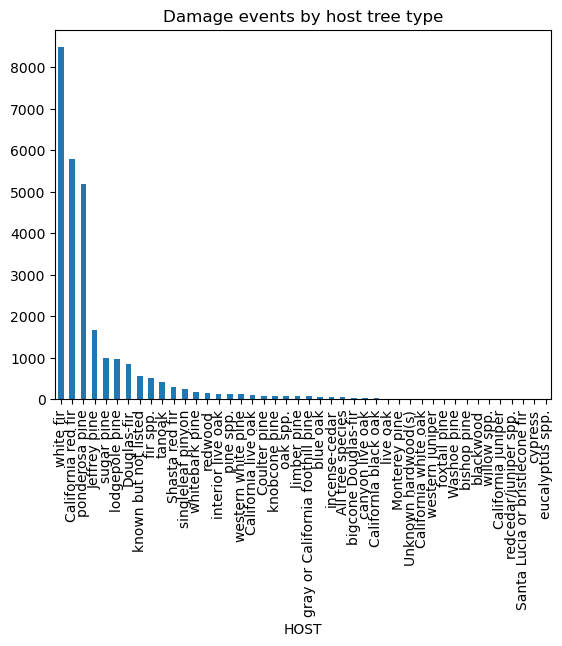

In [4]:
damage_sub['HOST'].value_counts().plot(kind='bar')
plt.title("Damage events by host tree type")
plt.show()

### Map of damage in 2018

<Axes: >

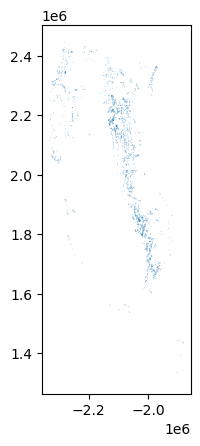

In [5]:
damage_sub[damage_sub["YEAR"] == 2018].plot()

### Reproject to 4326 and save

In [6]:
damage_reproj = damage_sub.to_crs("EPSG:4326")
damage_reproj.to_file("data_working/damage/damage_polygons.shp")

### Upload to GCS

In [7]:
!gcloud storage cp data_working/damage/* gs://ads-features

Copying file://data_working\damage\damage_polygons.shp to gs://ads-features/damage_polygons.shp
Copying file://data_working\damage\damage_polygons.shx to gs://ads-features/damage_polygons.shx
  
Copying file://data_working\damage\damage_polygons.dbf to gs://ads-features/damage_polygons.dbf
Copying file://data_working\damage\damage_polygons.cpg to gs://ads-features/damage_polygons.cpg
Copying file://data_working\damage\damage_polygons.prj to gs://ads-features/damage_polygons.prj
...................................................

Average throughput: 5.5MiB/s


### Ingest from GCS bucket --> GEE asset

In [11]:
!earthengine upload table --asset_id=projects/forest-lst/assets/damage_polygons gs://ads-features/damage_polygons.shp

Started upload task with ID: K53M4J3QEOO4CMKIZYP66JUD
